# Notebook for Quality Control demonstration of tonykong.me

This notebook aims for storing calculations and demonstrations of blo related to quality controls in tonykong.me. This notebook will be devided by the date release of a blog article, and will further devide by each of the functions demonstrated in that article.

## Blog on 16 September 2023

### 1. Demonstration of CDF of Gaussian distribution under 1s

In [4]:
#import numpy and matplotlib
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

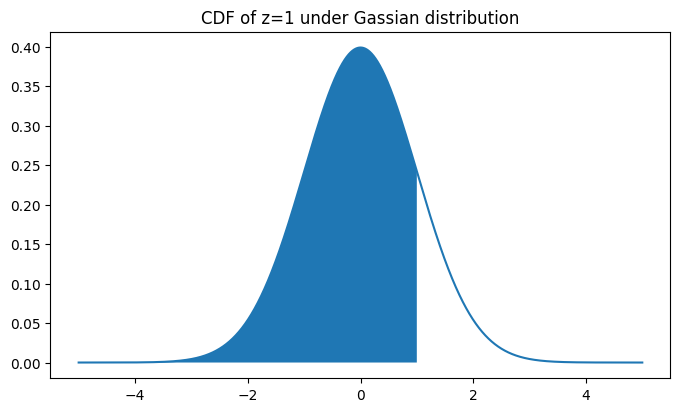

In [13]:
#create an array from -5 to 5 with interval of 0.001
n_range = np.arange(-5, 5, 0.001)

#plot the curve in matplotlib plotting chart
plt.figure(figsize = (8, 4.5))
plt.plot(n_range, st.norm.pdf(n_range, 0, 1))

#plot the area under curve between -5 to 1, to mimick the cdf of z-score = 3abs
plot_range = n_range[n_range<1]
plt.fill_between(plot_range, 0, st.norm.pdf(plot_range, 0, 1))
plt.title('CDF of z=1 under Gassian distribution')
plt.show()